# **Preprocessing** 


**Omer Kamal Ali Ebead**

**import the libraries**

In [1]:
import tensorflow as tf
import os
import pandas as pd
import xml.etree.ElementTree as ET
from PIL import Image
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import img_to_array
import numpy as np
from tensorflow.keras.layers import Input
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, BatchNormalization, Lambda
from sklearn.metrics import average_precision_score
import keras
from keras.layers import Flatten
import math

**load all the images names from their corresponding files**

In [2]:
def load_image_names(path):
    with open(path, 'r') as f:
        return [line.strip() for line in f.readlines()]

train_images = load_image_names('/kaggle/input/veri-dataset/VeRi/name_train.txt')
test_images = load_image_names('/kaggle/input/veri-dataset/VeRi/name_test.txt')
query_images = load_image_names('/kaggle/input/veri-dataset/VeRi/name_query.txt')


**load labels for train and test from the xml file**

In [3]:
def load_labels(xml_file):
    with open(xml_file, 'rb') as f:
        content = f.read()
    content = content.decode('gb2312')
    
    root = ET.fromstring(content)
    
    labels = {}
    for item in root.find('Items').findall('Item'):
        img_id = item.get('imageName')
        vehicle_id = item.get('vehicleID')
        labels[img_id] = vehicle_id
    return labels

train_labels = load_labels('/kaggle/input/veri-dataset/VeRi/train_label.xml')
test_labels = load_labels('/kaggle/input/veri-dataset/VeRi/test_label.xml')


**Load the training images**

In [4]:
def load_images(image_dir, labels):
    images = []
    for img_name, vehicle_id in labels.items():
        img_path = os.path.join(image_dir, img_name)
        if os.path.exists(img_path):
            img = Image.open(img_path)
            images.append((img, vehicle_id))
    return images

train_images = load_images('/kaggle/input/veri-dataset/VeRi/image_train', train_labels)


**Prepare the images to visualize different label images**

In [5]:
target = 18
labels = []
different_imgs = []

for i in range(len(train_images)):
        if len(labels) == target:
            break
        else:
            if train_images[i][1] in labels:
                continue
            else:
                different_imgs.append(train_images[i][0])
                labels.append(train_images[i][1])
    

**Visulaize the training images**

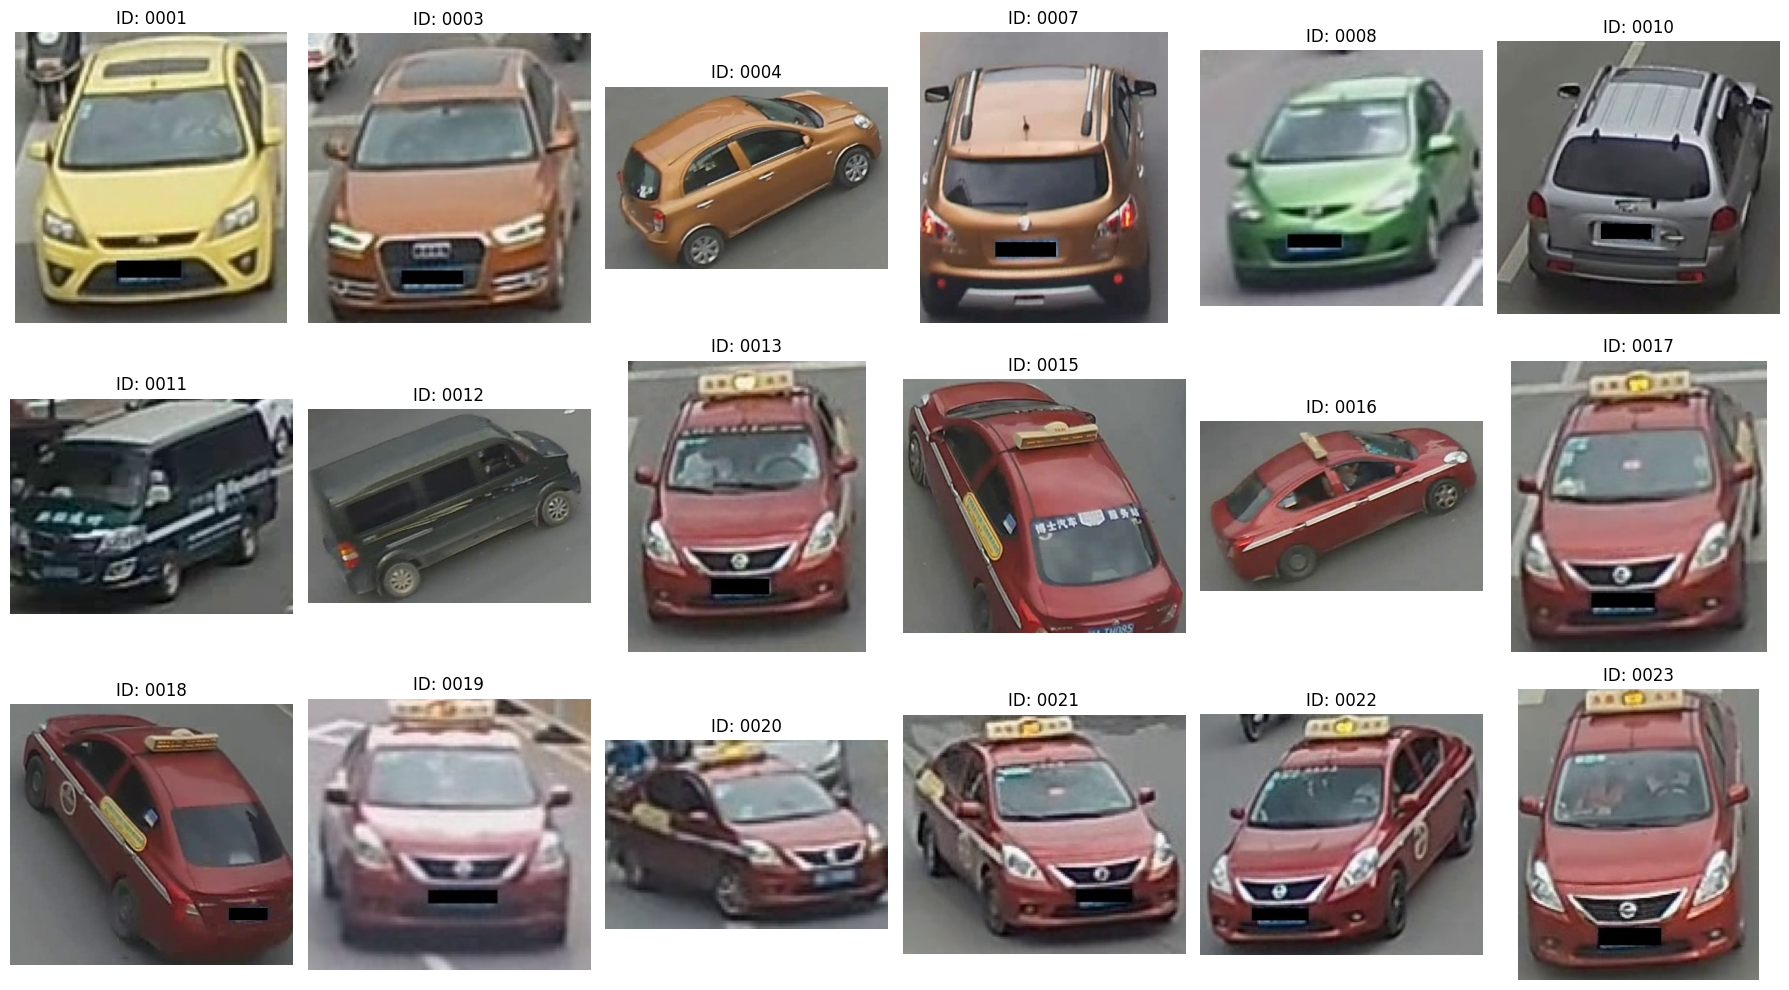

In [6]:
fig, ax = plt.subplots(3, 6, figsize=(18, 10))

for i, axi in enumerate(ax.flat):
    axi.imshow(different_imgs[i])
    axi.set_title(f'ID: {labels[i]}')  
    axi.axis('off') 

plt.tight_layout()  
plt.show()
    

# **Create The Model**

**I used InceptionV3 with non trainable weights and without a classifier**

In [7]:
input_layer = Input(shape=(160, 160, 3))

base_model = tf.keras.applications.InceptionV3(weights='imagenet', include_top=False)
x = base_model(input_layer)
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = Dense(256, activation=None)(x)


embedding_model = Model(inputs=input_layer, outputs=x)

embedding_model.summary()


87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ inception_v3 (Functional)       │ (None, 3, 3, 2048)     │    21,802,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 18432)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     9,437,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,371,808 (119.67 MB)

 Trainable params: 31,337,376 (119.54 MB)

 Non-trainable params: 34,432 (134.50 KB)

**I defined the triplet loss**
**it receices 3 images and return the loss with respect to the triplet formula**

In [8]:
def triplet_loss(margin=0.2):
    def loss(y_true, y_pred):
        anchor, positive, negative = y_pred[:, 0, :], y_pred[:, 1, :], y_pred[:, 2, :]
        pos_dist = tf.reduce_sum(tf.square(anchor - positive), axis=1)
        neg_dist = tf.reduce_sum(tf.square(anchor - negative), axis=1)
        loss_value = tf.maximum(pos_dist - neg_dist + margin, 0.0)
        return tf.reduce_mean(loss_value)
    return loss


**The training generator**

* It receive the training data and randomly select an ancor image and calculate its embeddings

* i am now doing it online mining  with p = 5 and k = 5 and i tried to do different mining stratiegies but all of them took time and GPU units i dont have.

* the one i am using now will randomly select 5 labels and find 5 images for each label which result in 25 images

* then choose triplets randomly from these candidates

* in my other mining stratigies ( which i delete due to above reasons )

* it gets 10 possibel candidate for that anchor image in terms of positive and negative candidates

* then it calculate the distance between the anchor and the candidates

* then the hard positive one is chosen which is the farest positive from the anchor

* sort the negative so that the closest negative is first

* then use next() to find the first negative that has a greater distance than the smallest positive distance in positive_distances (positive_distances[-1][1]). This ensures that the negative is farther from the anchor than the hardest positive, but still reasonably close.

* resize, normalize and convert to array steps for the triplets


In [29]:
import random
import numpy as np
from tensorflow.keras.preprocessing.image import img_to_array

def compute_embedding(embedding_model, img, target_size=(160, 160)):
    img_resized = img_to_array(img.resize(target_size)) / 255.0
    img_resized = np.expand_dims(img_resized, axis=0)
    embedding = embedding_model.predict(img_resized, verbose=0)
    return embedding

def generate_triplets_from_selected_images(label_images, batch_size, target_size=(160, 160)):
    anchor_images = []
    positive_images = []
    negative_images = []

    for _ in range(batch_size):
        anchor_label = random.choice(list(label_images.keys()))
        images = label_images[anchor_label]

        if len(images) < 2:
            print(f"Label {anchor_label} does not have enough images for anchor-positive pairing.")
            continue

        anchor_idx, positive_idx = random.sample(range(len(images)), 2)
        anchor_image = images[anchor_idx]
        positive_image = images[positive_idx]

        negative_label = random.choice([l for l in label_images.keys() if l != anchor_label])
        negative_image = random.choice(label_images[negative_label])

        anchor_images.append(img_to_array(anchor_image.resize(target_size)) / 255.0)
        positive_images.append(img_to_array(positive_image.resize(target_size)) / 255.0)
        negative_images.append(img_to_array(negative_image.resize(target_size)) / 255.0)

    return (np.array(anchor_images), np.array(positive_images), np.array(negative_images)), np.zeros((batch_size, 1))

def triplet_generator(image_data, embedding_model, batch_size, ulabels, target_size=(160, 160)):
    while True:
        selected_labels = random.sample(list(ulabels.keys()), min(5, len(ulabels)))
        label_images = {label: [] for label in selected_labels}

        for img, label in image_data:
            if label in selected_labels and len(label_images[label]) < 5:
                label_images[label].append(img)
        
        triplets, labels = generate_triplets_from_selected_images(label_images, batch_size, target_size)

        yield triplets, labels


* specify the triplet model to have 3 input images and returns 3 (in stack) output embeddings.

In [11]:

class MyLayer(tf.keras.layers.Layer):
    def call(self, inputs): 
        return tf.stack(inputs, axis=1)

    
input_shape = (160, 160, 3)
anchor_input = Input(shape=input_shape, name='anchor_input')
positive_input = Input(shape=input_shape, name='positive_input')
negative_input = Input(shape=input_shape, name='negative_input')

anchor_embedding = embedding_model(anchor_input)
positive_embedding = embedding_model(positive_input)
negative_embedding = embedding_model(negative_input)

merged_output = MyLayer()([anchor_embedding, positive_embedding, negative_embedding])

triplet_model = tf.keras.Model(inputs=[anchor_input, positive_input, negative_input], outputs=merged_output)



In [12]:
triplet_model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ anchor_input        │ (None, 160, 160,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ positive_input      │ (None, 160, 160,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ negative_input      │ (None, 160, 160,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_1        │ (None, 256)       │ 31,371,808 │ anchor_input[0][… │
│ (Functional)        │                   │            │ positive_input[0… │
│                     │                   │            │ negative_input[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ my_layer (MyLayer)  │ (None, 3, 256)    │          0 │ functional_1[0][… │
│                     │                   │            │ functional_1[1][… │
│                     │                   │            │ functional_1[2][… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 31,371,808 (119.67 MB)

 Trainable params: 31,337,376 (119.54 MB)

 Non-trainable params: 34,432 (134.50 KB)

* split the train data to be train and validate and ensure no label in the train set appears in the validation sets

In [13]:
def train_validate_split(train_images):
    labels = []
    for i in train_images:
        if i[1] in labels:
            continue
        else:
            labels.append(i[1])
    
    num_of_labels = len(labels)
    labels_in_train = labels[50:]
    labels_in_validation = labels[0:50]
    train_data = []
    validation_data = []
    for i in train_images:
        if i[1] in labels_in_train:
            train_data.append(i)
        else:
            validation_data.append(i)
    return train_data,validation_data
        

train_data,validation_data = train_validate_split(train_images)

* i used this code to get the unique labels for train data

In [14]:
ulabels = {}
train_data2 = []
for i in range(len(train_data)):
    if train_data[i][1] in ulabels.keys():
        if ulabels[train_data[i][1]] > 20:
            continue
        else:
            train_data2.append(train_data[i])
            ulabels[train_data[i][1]] = ulabels[train_data[i][1]] + 1
            
    else:
        ulabels[train_data[i][1]] = 1
        train_data2.append(train_data[i])
            
    

* extract the embeddings for the validation data

In [15]:
def extract_embeddings_train(model, images):
    embeddings = []

    for img in images:
        img = np.array(img)/255.0
        img = tf.expand_dims(img,axis=0)
        emb = model.predict(img,verbose=0)
        embeddings.append(emb)
    return np.vstack(embeddings)


* loop through the validation set and add unique query images to the query set and the other images to the test set

In [16]:
def triplet_generator_Validation(image_data , target_size=(160, 160)):
    
        query_images = []
        test_images = []

        query_idxs = []
        query_labels = []
        test_labels = []
        

        for i in range(0,len(image_data)):
            if image_data[i][1] in query_labels:
                continue
            else:           
                query_image, query_label = image_data[i]
                query_image_resized = query_image.resize(target_size)
                query_images.append(query_image_resized)
                query_labels.append(query_label)
                query_idxs.append(i)
               


        for i in range(len(image_data)):
            if i in query_idxs:
                continue
            else:
                test_img = image_data[i][0].resize(target_size)
                test_images.append(test_img)
                test_labels.append(image_data[i][1])
               
             
        print('/n')
        print('extracting validation features')
        print(f' length of the query images {len(query_images)}')
        
        return query_images,query_labels,test_images,test_labels

In [17]:
query_images_val,query_labels_val,test_images_val,test_labels_val=triplet_generator_Validation(validation_data , target_size=(160, 160))

/n
extracting validation features
 length of the query images 50


for each query, i found how many test images has its labels and i saved the number there ( will be used in mAP calculations)

In [18]:
query_labels_count = []

for i in query_labels_val:
    n = 0
    for j in test_labels_val:
        if i == j:
            n += 1
        else:
            continue
    query_labels_count.append(n)

* loop through all the query embeddings 
* for each query calculate the Eculidian distance from the query and all the test images
* sort the distance by indexes
* change the indexes to its corresponding labels 
* compare the indexes with the true query index and create an array of similarity where :
* if we are in the first n elements ( the number of labels matches the query label in the test data ) ->
0 = different label (predicted near and it should be far) 
1 = same label ( predicted near and it should be near )
* if we are not in the first n elements ->
0 = same label (predicted far and it should be close)
1 = different labels (predicted far and it is far)

* i created a function to calculate average percision


 

In [19]:
def compute_AP(relevant,n):
    relevant_count= 0
    precision_at_relevant = []
    for i in range(n):
        if relevant[i] == 1:
            relevant_count += 1
            precision = relevant_count / (i + 1) 
            precision_at_relevant.append(precision)

    return np.mean(precision_at_relevant)

    

In [20]:
def compute_map(query_embeddings, query_labels, test_embeddings, test_labels,query_labels_count):
    average_precisions = []
    sorted_indices_list = []
    relevants = []

    for i, query_emb in enumerate(query_embeddings):
        distances = np.linalg.norm(test_embeddings - query_emb, axis=1)
        sorted_indices = np.argsort(distances)
        test_labels = np.array(test_labels)
        sorted_labels = np.empty(len(sorted_indices),dtype=test_labels.dtype)
        for k, j in enumerate(sorted_indices):
            sorted_labels[k] = test_labels[j]
        
        n = query_labels_count[i]
        true_label = query_labels[i]
        relevant = []
        for k,j in enumerate(sorted_labels):
            if k > n:
                if j == true_label:
                    relevant.append(1)
                else:
                    relevant.append(0)
                    
            else:
                if j == true_label:
                    relevant.append(1)
                else:
                    relevant.append(0)
       
        
        relevants.append(relevant)
        sorted_indices_list.append(sorted_indices)
        ap = compute_AP(relevant,n)
        average_precisions.append(ap)
    cleaned_ap_scores = [score for score in average_precisions if not math.isnan(score)]
    return np.mean(cleaned_ap_scores),sorted_indices_list,relevants,average_precisions

* i used this callback to calculate the mAP for validation steps (when the epoch finish)

In [21]:
class MAPCallback(tf.keras.callbacks.Callback):
    def __init__(self, val_data,embedding_model):
        super(MAPCallback, self).__init__()
        self.val_data = val_data
        self.embedding_model = embedding_model
        
    
    def on_epoch_end(self, epoch, logs=None):

        query_images_val,query_labels_val,test_images_val,test_labels_val,query_labels_count=self.val_data
        query_embeddings_val = extract_embeddings_train(self.embedding_model, query_images_val)
        test_embeddings_val = extract_embeddings_train(self.embedding_model, test_images_val)

        mAP,sorted_indices_list,relevants,average_precisions = compute_map( query_embeddings_val,query_labels_val,test_embeddings_val,test_labels_val,query_labels_count)
        print('\n')
        print(f"Mean Average Precision (mAP): {mAP}")


* i used adam as optimizer and triplet loss as loss function 
* i fit with the generator 
* epochs = 5
* batch size = 1 (do to time + each batch 25 triplets are generated )
* added validation mAP calculation as a callback 

In [31]:
batch_size = 1
epochs = 5

triplet_model.compile(optimizer=tf.keras.optimizers.Adam(), loss=triplet_loss(margin=1))

history = triplet_model.fit(
    triplet_generator(train_data,embedding_model,batch_size,ulabels),
    steps_per_epoch= 100,
    epochs=epochs,
    callbacks=[MAPCallback(( query_images_val,query_labels_val,test_images_val,test_labels_val,query_labels_count),embedding_model )]
)

Epoch 1/5


I0000 00:00:1730049182.459277     200 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_maximum_fusion_50', 8 bytes spill stores, 8 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_maximum_fusion_49', 8 bytes spill stores, 8 bytes spill loads



100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 31.8640

/opt/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)




Mean Average Precision (mAP): 0.22480031655443594
100/100 ━━━━━━━━━━━━━━━━━━━━ 397s 3s/step - loss: 31.7237
Epoch 2/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 0.6657

Mean Average Precision (mAP): 0.20802657431753446
100/100 ━━━━━━━━━━━━━━━━━━━━ 270s 3s/step - loss: 0.6687
Epoch 3/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 0.7477

Mean Average Precision (mAP): 0.220617485022102
100/100 ━━━━━━━━━━━━━━━━━━━━ 271s 3s/step - loss: 0.7461
Epoch 4/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 0.3925

Mean Average Precision (mAP): 0.2278908780113181
100/100 ━━━━━━━━━━━━━━━━━━━━ 266s 3s/step - loss: 0.3924
Epoch 5/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 0.3492

Mean Average Precision (mAP): 0.20825323552470523
100/100 ━━━━━━━━━━━━━━━━━━━━ 272s 3s/step - loss: 0.3501


# **Testing**

i load the query and test images

In [33]:
import os
from PIL import Image

def load_images(image_dir,labels):
    images = []
    for img_name in labels:
        img_path = os.path.join(image_dir, img_name)
        if os.path.exists(img_path):
            img = Image.open(img_path)
            images.append(img)
    return images


query_imgs = load_images("/kaggle/input/veri-dataset/VeRi/image_query/",query_images)
test_imgs = load_images("/kaggle/input/veri-dataset/VeRi/image_test/",test_images)

In [34]:
def extract_embeddings(model, images):
    embeddings = []

    for img in images:
        img = np.array(img.resize((160,160)))/255.0
        img = tf.expand_dims(img,axis=0)
        emb = model.predict(img,verbose=0)
        embeddings.append(emb)
    return np.vstack(embeddings)


i extracted the embeddings for all querys and test images 

In [35]:
query_embeddings = extract_embeddings(embedding_model, query_imgs)

In [36]:
test_embeddings = extract_embeddings(embedding_model, test_imgs)


get the labels for the query images and test images

In [37]:
query_labels = []
for lbl in query_images:
    query_labels.append(lbl.split("_")[0])

test_labels = []
for lbl in test_images:
    test_labels.append(lbl.split("_")[0])



label count for the query images (same as in training)

In [38]:
query_labels_count = []

for i in query_labels:
    n = 0
    for j in test_labels:
        if i == j:
            n += 1
        else:
            continue
    query_labels_count.append(n)

**Results** 

In [40]:
mAP,sorted_indices_list,relevants,average_precisions = compute_map(query_embeddings,query_labels,test_embeddings,test_labels,query_labels_count)

0006


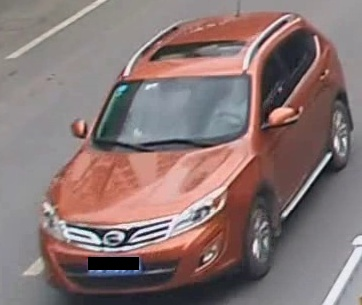

In [59]:
k = 20

print(query_labels[k])
query_imgs[k]

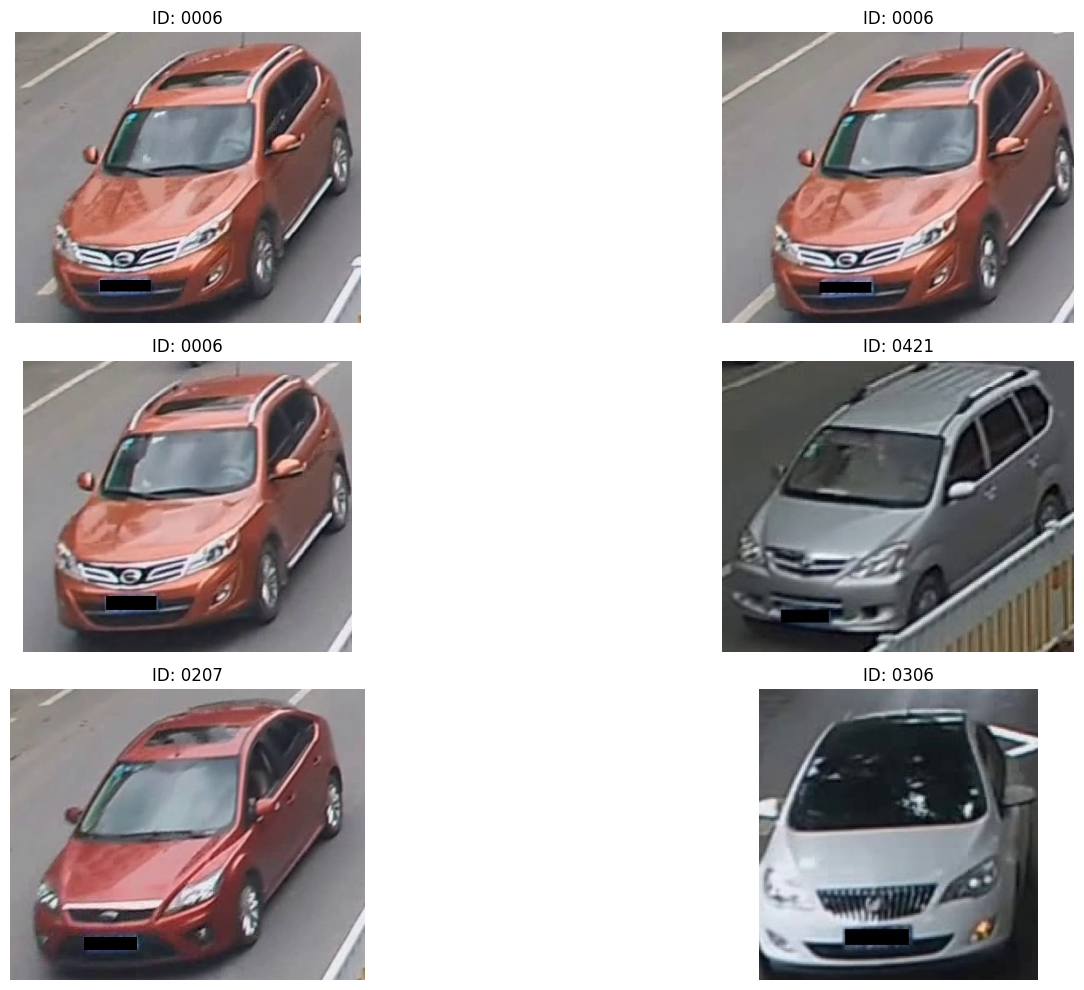

In [60]:
fig, ax = plt.subplots(3, 2, figsize=(18, 10))


indexes = sorted_indices_list[k][0:18]
for i, axi in enumerate(ax.flat):
    axi.imshow(test_imgs[indexes[i]])
    axi.set_title(f'ID: {test_labels[indexes[i]]}')  
    axi.axis('off') 

plt.tight_layout()  
plt.show()


In [41]:
mAP

0.6957113902125732